# Exploratory data analysis

In [1]:
# load json
import json
with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/voc_all.json') as f:
    all_data=json.load(f)
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/train_new.json') as g:
#     train=json.load(g)  
# with open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/annotation/val_new.json') as h:
#     val=json.load(h)

In [2]:
print('number category: {}'.format(len(all_data['categories'])))
all_data['categories']

number category: 4


[{'name': 'holothurian', 'id': 0},
 {'name': 'echinus', 'id': 1},
 {'name': 'scallop', 'id': 2},
 {'name': 'starfish', 'id': 3}]

In [3]:
print('训练图片数量: {}'.format(len(all_data['images'])))
print('训练标签数量: {}'.format(len(all_data['annotations'])))

训练图片数量: 5543
训练标签数量: 41441


In [4]:
total=[]
for img in all_data['images']:
    wh=(img['width'], img['height'])
    total.append(wh)
unique=set(total)
for k in unique:
    print('训练图片长宽为({}, {})的数量: {}'.format(k[0], k[1], total.count(k)))

训练图片长宽为(704, 576)的数量: 38
训练图片长宽为(1920, 1080)的数量: 596
训练图片长宽为(3840, 2160)的数量: 1712
训练图片长宽为(720, 405)的数量: 3153
训练图片长宽为(586, 480)的数量: 44


In [5]:
anns_id = []
images_id = []
for anns in all_data['annotations']:
    anns_id.append(anns['id'])
    images_id.append(anns['image_id'])
print('训练集图片数量: ', len(all_data['images']))
print('unique id 数量: ', len(set(anns_id)))
print('unique image_id 数量: ', len(set(images_id)))

训练集图片数量:  5543
unique id 数量:  41441
unique image_id 数量:  5455


**训练图片的id数量与标注对应的图片数量不匹配**，意味着可能存在标注错误或者图片缺失，因此需要对annos作进一步过滤

### 查看缺失图片数量

In [6]:
import os
unique_image = {'{:06d}'.format(img_id) for img_id in set(images_id)}
actual_images_names = os.listdir('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/image')
actual_images_id = [img_name.split('.')[0] for img_name in actual_images_names]
origin_list = set(actual_images_id)

gaps = origin_list - unique_image
print('缺少标注的图像数量：{} {}'.format(len(gaps), gaps))

缺少标注的图像数量：88 {'003196', '001132', '001126', '004202', '004003', '003197', '001156', '001141', '005212', '001152', '001155', '001120', '001161', '001138', '002222', '003201', '003195', '001146', '001164', '004634', '003200', '001125', '001130', '001139', '001151', '001145', '001121', '001143', '001137', '001160', '001134', '003203', '004326', '001159', '003206', '004001', '001136', '001140', '002704', '002978', '001142', '001118', '001149', '003569', '001129', '003207', '001144', '001124', '004022', '004007', '005410', '004025', '003205', '003518', '004004', '001119', '004024', '001131', '001442', '004023', '005531', '003198', '001154', '005156', '003199', '001150', '005255', '003204', '001148', '001158', '001441', '003208', '001133', '001147', '001122', '001162', '001128', '001127', '003176', '001157', '001153', '005211', '005210', '001135', '003202', '001123', '001163', '000447'}


gaps的元素在origin_list中存在，但是在unique_image中不存在,有88个文件没有标注信息，annotation为空那么在训练的过程中，全图为空，没有标注的图，应该删掉，或者使用mixup，增强特征

mmdetection会自动删除全图标注为空的样本

### 查看统计量

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [8]:
## 创建类别标签字典
category_dict = dict([(cate['id'], cate['name']) for cate in all_data['categories']])
category_dict

{0: 'holothurian', 1: 'echinus', 2: 'scallop', 3: 'starfish'}

In [9]:
counts_label_all=dict([(cate['name'], 0) for cate in all_data['categories']])
# counts_label_train=dict([(j['name'], 0) for j in train['categories']])
# counts_label_val=dict([(h['name'], 0) for h in val['categories']])
for anns in all_data['annotations']:
    counts_label_all[category_dict[anns['category_id']]] += 1
# for j in train['annotations']:  
#     counts_label_train[category_dic[j['category_id']]] += 1
# for n in val['annotations']:
#     counts_label_val[category_dic[n['category_id']]] += 1
    
print("总数据集每个类别的标注数量： {}".format(counts_label_all))
# print("train集每个类别的标注数量： {}".format(counts_label_train))
# print("val集每个类别的标注数量： {}".format(counts_label_val))

总数据集每个类别的标注数量： {'holothurian': 5537, 'echinus': 22343, 'scallop': 6720, 'starfish': 6841}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


                 0
holothurian   5537
echinus      22343
scallop       6720
starfish      6841


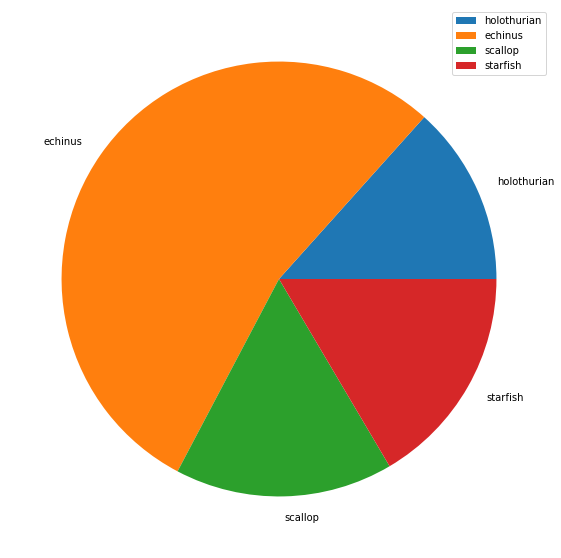

In [10]:
# 打印
%matplotlib inline 
plt.style.use({'figure.figsize':(10, 10)})
indices=counts_label_all.keys()
values=counts_label_all.values()
count_df=pd.DataFrame(list(values),index=indices)
print(count_df)
count_df.iloc[:,0].plot.pie()
plt.legend()
plt.axis('off')
plt.show()

<AxesSubplot:>

/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31614 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/alex/anaconda3/envs/pytorc

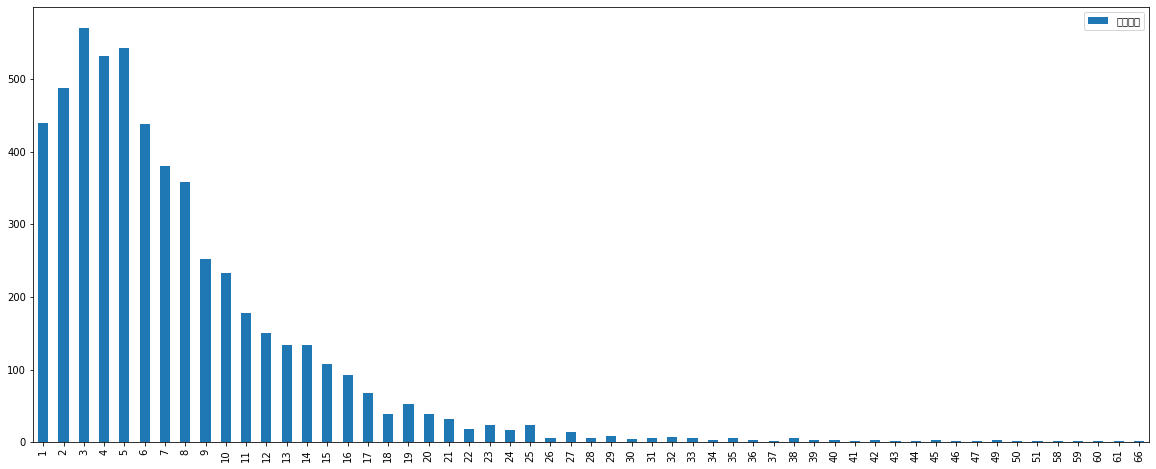

In [11]:
# 存在相同标签数量的图的数量的统计直方图
%matplotlib inline
plt.style.use({'figure.figsize':(20, 8)})
annoto_count={}
for i in all_data['annotations']:
    annoto_count[i['image_id']]=annoto_count.setdefault(i['image_id'],0)+1
indes_list=set(annoto_count.values())
values_count=[list(annoto_count.values()).count(i) for i in indes_list]
pd.DataFrame(values_count,index=indes_list,columns=['标签数量']).plot(kind='bar')
# 有1个标注的图的数量有440张
# 有3个标注的图的数量有580张

In [12]:
# 剔除冗余信息
annotations = []
for ann in all_data['annotations']:
    ann.pop('id')  # anns的标注id
    ann.pop('iscrowd')
    annotations.append(ann)
annotations[:5]

[{'segmentation': [712, 415, 839, 415, 839, 574, 712, 574],
  'area': 20193,
  'image_id': 1,
  'bbox': [712, 415, 127, 159],
  'category_id': 0,
  'ignore': 0},
 {'segmentation': [129, 940, 301, 940, 301, 1082, 129, 1082],
  'area': 24424,
  'image_id': 1,
  'bbox': [129, 940, 172, 142],
  'category_id': 1,
  'ignore': 0},
 {'segmentation': [344, 894, 468, 894, 468, 1003, 344, 1003],
  'area': 13516,
  'image_id': 1,
  'bbox': [344, 894, 124, 109],
  'category_id': 1,
  'ignore': 0},
 {'segmentation': [653, 799, 793, 799, 793, 925, 653, 925],
  'area': 17640,
  'image_id': 1,
  'bbox': [653, 799, 140, 126],
  'category_id': 1,
  'ignore': 0},
 {'segmentation': [342, 540, 469, 540, 469, 674, 342, 674],
  'area': 17018,
  'image_id': 1,
  'bbox': [342, 540, 127, 134],
  'category_id': 1,
  'ignore': 0}]

In [13]:
# 将标签于对应图片合并起来，形成新的数据格式
data = []
print(annotations)

per_sample = {}
for img in all_data['images']:
    sample_img = img
    annota_list = [] # 保存该图片对应的标签
    for per_anns in annotations:
        if per_anns['image_id']==img['id']:   # 将一张图的所有的ann装进annota_list中
            annota_list.append(per_anns)
    for k in annota_list:
        annotations.remove(k)   # 把拿出来的ann在总的标注文件中都删除掉
    sample_img['annotations'] = annota_list
    data.append(sample_img)
data[:5]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[{'file_name': '000001.jpg',
  'height': 1080,
  'width': 1920,
  'id': 1,
  'annotations': [{'segmentation': [712, 415, 839, 415, 839, 574, 712, 574],
    'area': 20193,
    'image_id': 1,
    'bbox': [712, 415, 127, 159],
    'category_id': 0,
    'ignore': 0},
   {'segmentation': [129, 940, 301, 940, 301, 1082, 129, 1082],
    'area': 24424,
    'image_id': 1,
    'bbox': [129, 940, 172, 142],
    'category_id': 1,
    'ignore': 0},
   {'segmentation': [344, 894, 468, 894, 468, 1003, 344, 1003],
    'area': 13516,
    'image_id': 1,
    'bbox': [344, 894, 124, 109],
    'category_id': 1,
    'ignore': 0},
   {'segmentation': [653, 799, 793, 799, 793, 925, 653, 925],
    'area': 17640,
    'image_id': 1,
    'bbox': [653, 799, 140, 126],
    'category_id': 1,
    'ignore': 0},
   {'segmentation': [342, 540, 469, 540, 469, 674, 342, 674],
    'area': 17018,
    'image_id': 1,
    'bbox': [342, 540, 127, 134],
    'category_id': 1,
    'ignore': 0},
   {'segmentation': [1668, 251, 1834

In [14]:
# 定义一个画图函数
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import colorsys
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    

color_dict = {'echinus': 'red', 'starfish':'green', 'holothurian':'blue', 'scallop':'yellow'}

def plot_imgs(img_data,gap=10,path=''):
    files_name=img_data['file_name']
    img_annotations=img_data['annotations']
    n=len(img_annotations)
    boxs=np.zeros((n,4), dtype=np.int32)
    tags=[]
    img=Image.open('/media/alex/80CA308ECA308288/alex_dataset/URPC-2020/train/image/'+ files_name) #图片路径
    img_w=img.size[0]
    img_h=img.size[1]
    for i in range(n):
        bbox=img_annotations[i]['bbox']
        tags.append(category_dict[img_annotations[i]['category_id']])
        y1 = max(0, np.floor(bbox[1] + 0.5))
        x1 = max(0, np.floor(bbox[0] + 0.5))
        y2 = min(img_h, np.floor(bbox[1]+bbox[3] + 0.5))
        x2= min(img_w, np.floor(bbox[0]+bbox[2] + 0.5))
        boxs[i]=[x1,y1,x2,y2]
    print('image shape ({}{})'.format(img_w, img_h))
    # set font
    font = ImageFont.truetype(font=fm.findfont(fm.FontProperties()), size=np.floor(1.5e-2 * img_w + 15).astype(np.int32),encoding="unic")
    
    draw = ImageDraw.Draw(img)
    for box, tag in zip(boxs, tags):
        # get label size
        label_size = draw.textsize(tag, font)

        # get label start point
        text_origin = np.array([box[0], box[1] - label_size[1]])

        # 绘制矩形框，加入label文本
        draw.rectangle([box[0], box[1], box[2], box[3]],outline=color_dict[tag],width=2)
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=color_dict[tag])
        draw.text(text_origin, str(tag), fill=(255, 255, 255), font=font)

    plt.style.use({'figure.figsize':(20, 10)})
    plt.imshow(img)  

image shape (19201080)


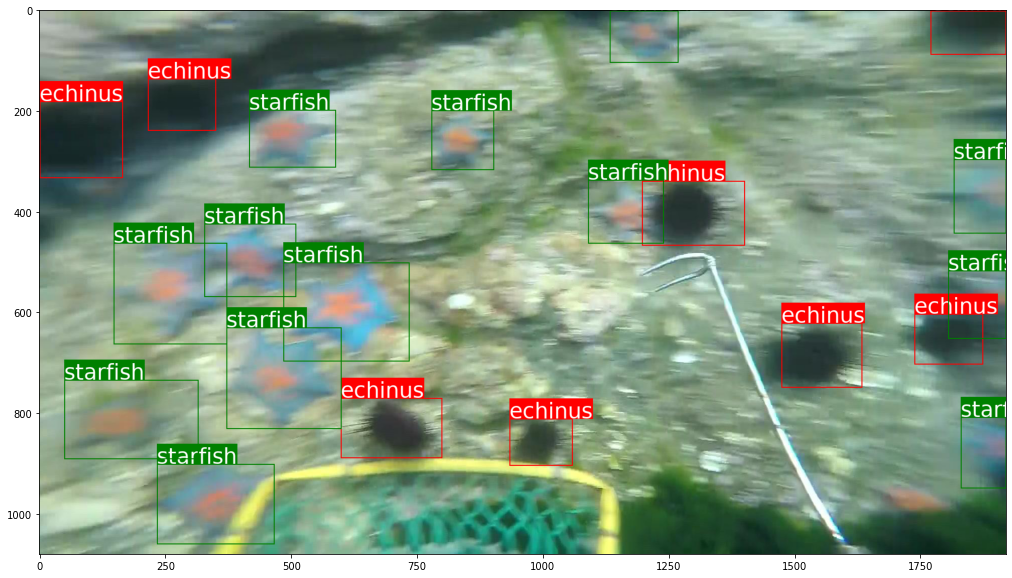

In [15]:
for d in data:
    if len(d['annotations'])==21:
        break
plot_imgs(d,gap=2,path='')

宽高比1.0: 数量:34075
宽高比2.0: 数量:6568
宽高比3.0: 数量:705
宽高比4.0: 数量:75
宽高比5.0: 数量:12
宽高比6.0: 数量:2
宽高比7.0: 数量:3
宽高比21.0: 数量:1


/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 23485 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/alex/anaconda3/envs/pytorch/

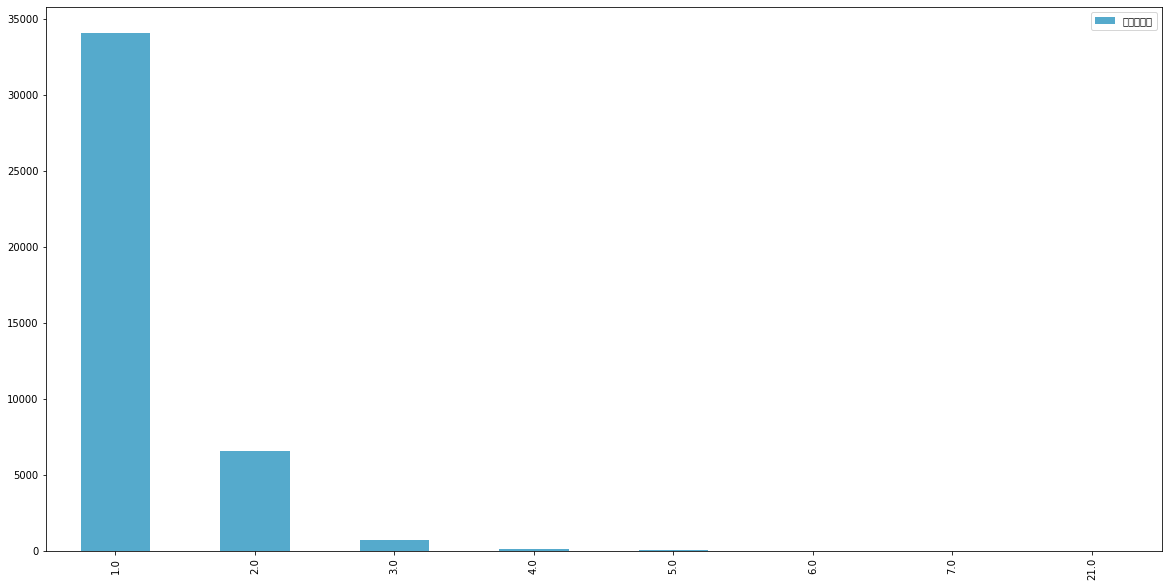

In [16]:
# 对所有标注长宽做统计
total_size=[]
total_height=[]
total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        # total_width += [b['bbox'][2]]
        # total_height += [b['bbox'][3]]
        wh = round(b['bbox'][2]/b['bbox'][3], 0)
        if wh < 1 :
            wh = round(b['bbox'][3]/b['bbox'][2],0)
        total_wh += [wh]

# 所有标签的长宽高比例
box_wh_unique = list(set(total_wh))
box_wh_count=[total_wh.count(i) for i in box_wh_unique]

bbox_wh_dict = {}
for i, key in enumerate(box_wh_unique):
    print('宽高比{}: 数量:{}'.format(key, box_wh_count[i]))

# 绘图
wh_df = pd.DataFrame(box_wh_count,index=box_wh_unique,columns=['宽高比数量'])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()

<AxesSubplot:>

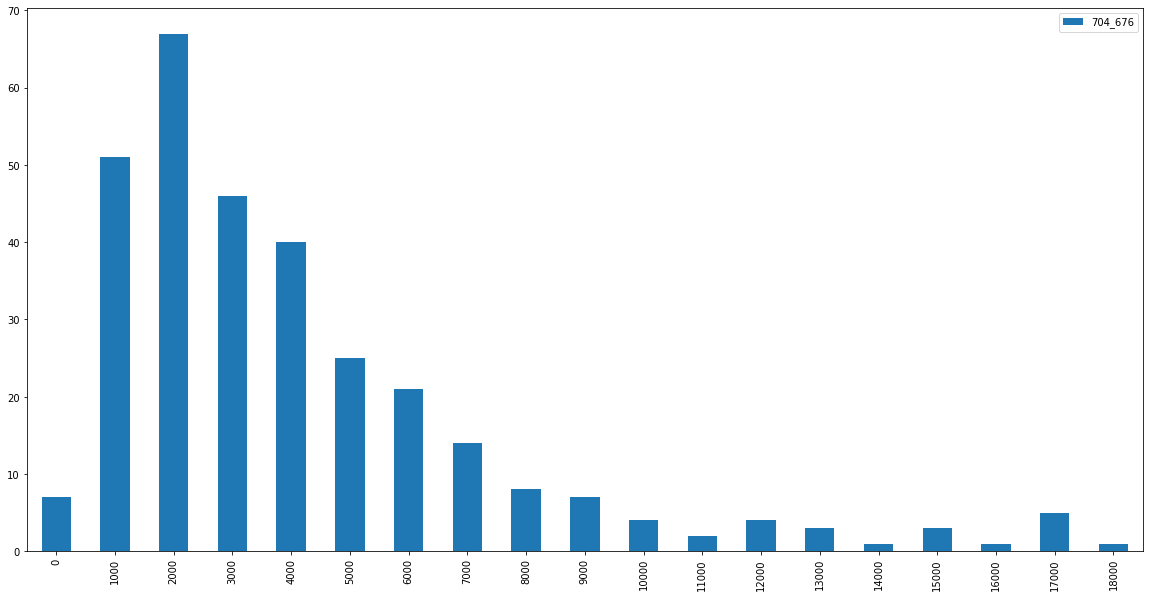

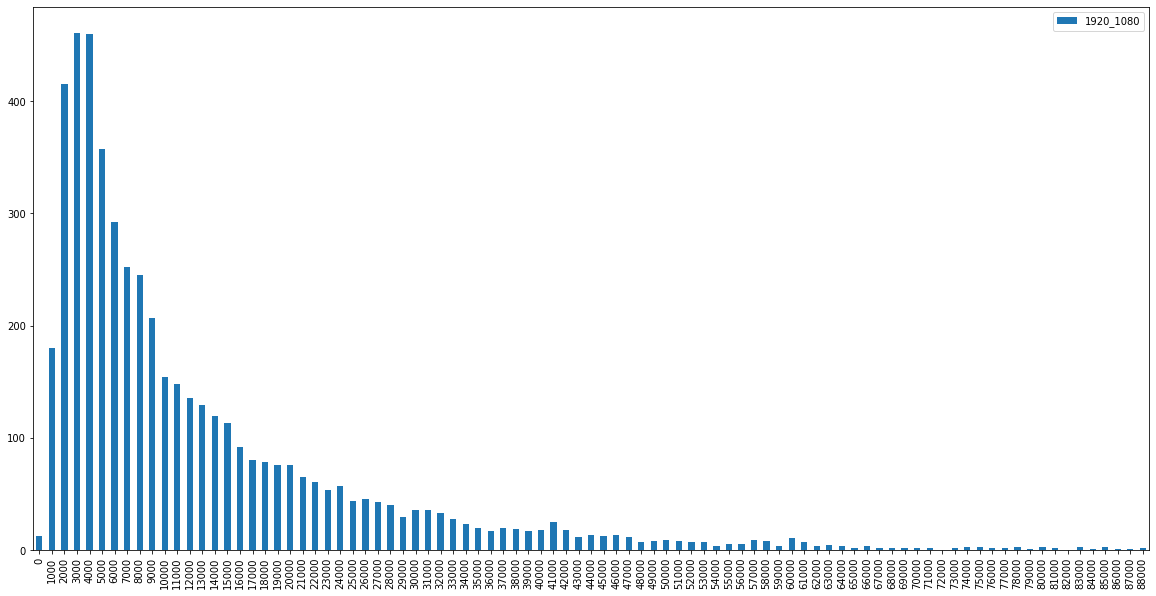

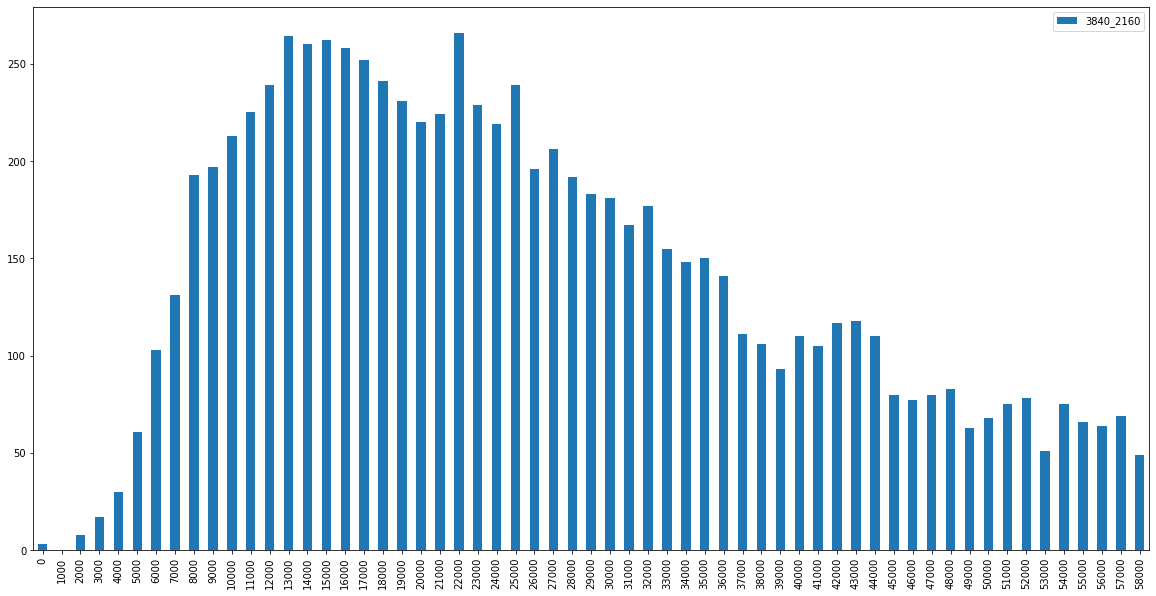

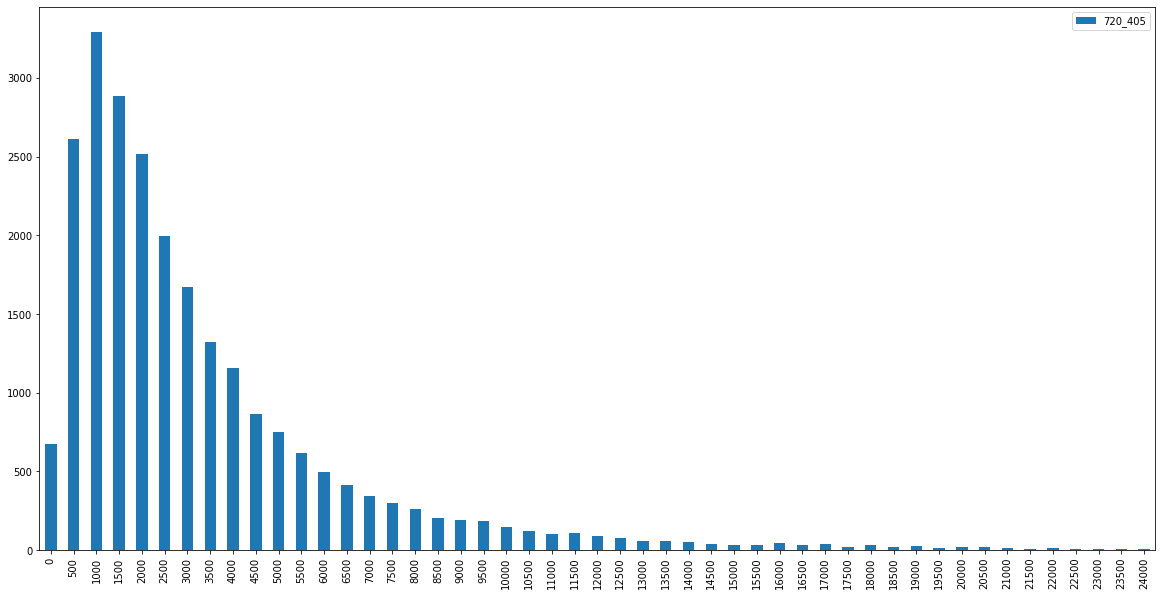

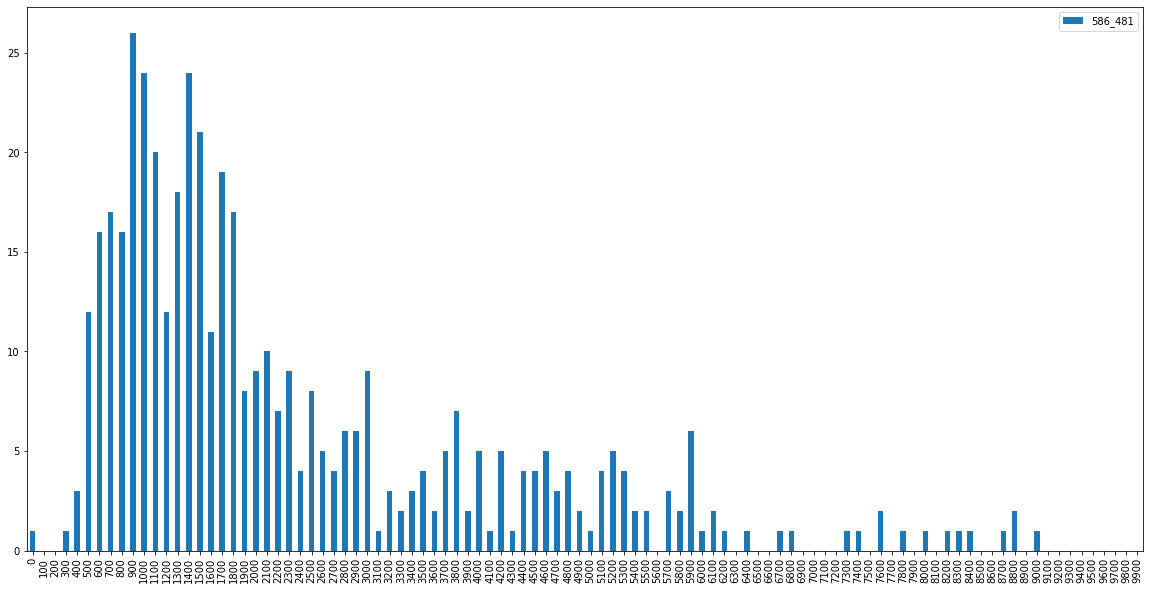

In [17]:
# 对所有标注面积比做统计
total_size_704_676=[]
total_size_1920_1080=[]
total_size_3840_2160=[]
total_size_720_405=[]
total_size_586_481=[]

total_wh=[]

for im in data:                     # 每张图的信息
    for b in im['annotations']:     # 每张图的每个标注
        if (im['width'], im['height']) == list(unique)[0]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size_704_676 += [size]
        elif (im['width'], im['height']) == list(unique)[1]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size_1920_1080 += [size]
        elif (im['width'], im['height']) == list(unique)[2]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size_3840_2160 += [size]
        elif (im['width'], im['height']) == list(unique)[3]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size_720_405 += [size]
        elif (im['width'], im['height']) == list(unique)[4]:
            size = round(b['bbox'][2] * b['bbox'][3])
            total_size_586_481 += [size]


max_size = max(total_size_704_676)
gap = 1000
group_names = list(range(0,20000,gap))
size_cuts = pd.cut(total_size_704_676,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'704_676':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size_1920_1080)
gap = 1000
group_names = list(range(0,90000,gap))
size_cuts = pd.cut(total_size_1920_1080,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'1920_1080':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size_3840_2160)
gap = 1000
group_names = list(range(0,60000,gap))
size_cuts = pd.cut(total_size_3840_2160,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'3840_2160':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size_720_405)
gap = 500
group_names = list(range(0,25000,gap))
size_cuts = pd.cut(total_size_720_405,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'720_405':size_cuts.value_counts()})
total_df.plot(kind='bar')

max_size = max(total_size_586_481)
gap = 100
group_names = list(range(0,max_size,gap))
size_cuts = pd.cut(total_size_586_481,bins=group_names,labels=group_names[:-1])
total_df=pd.DataFrame({'586_481':size_cuts.value_counts()})
total_df.plot(kind='bar')